In [1]:
from imports import *

**load data**

In [2]:
# Leer el archivo Parquet
table_loaded = pq.read_table("6'_5ophits.parquet")

# Convertir de vuelta a Awkward Array o NumPy
input = ak.to_numpy(table_loaded["input"])
nuvT_c = ak.to_numpy(table_loaded["nuvT_c"])

print("Loaded matrix shape:", input.shape)  # Debería ser (21900, 400, 4)
print("Loaded vector shape:",nuvT_c.shape)  # Debería ser (21900,))
print("Matrix sample:\n", input[0, :3])
print("Vector sample:", nuvT_c[:3])

Loaded matrix shape: (21964, 20, 4)
Loaded vector shape: (21964,)
Matrix sample:
 [[1478.72460015   70.            0.            0.        ]
 [1480.72460015   16.            0.            0.        ]
 [1480.72460015   14.            0.            0.        ]]
Vector sample: [1462.42688725 1480.24647869  643.02543649]


In [3]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(input, nuvT_c, test_size=0.2, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Modelo clásico**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, ELU
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(20,4))
masked_inputs, mask = MaskNegative1000()(inputs)

lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)

x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
x = LeakyReLU(alpha=0.1)(x)  # Aplicando LeakyReLU
x = Dropout(0.3)(x)
outputs = Dense(1)(x)

model11 = Model(inputs, outputs)
model11.compile(optimizer='adam', loss='mse', metrics=['mae'])
model11.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 20, 4)]      0           []                               
                                                                                                  
 mask_negative1000_10 (MaskNega  ((None, 20, 4),     0           ['input_11[0][0]']               
 tive1000)                       (None, 20))                                                      
                                                                                                  
 lstm_20 (LSTM)                 (None, 20, 256)      267264      ['mask_negative1000_10[0][0]',   
                                                                  'mask_negative1000_10[0][1]']   
                                                                                            

**Modo Boosted**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, Masking, Attention
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Creamos la máscara para valores que no sean -1000
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        mask = tf.cast(mask, dtype=tf.float32)  # Convertimos la máscara a float32 para su uso en la red
        # Aplicamos la máscara multiplicando por los datos
        return inputs * tf.expand_dims(mask, -1), mask

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    masked_inputs, mask = MaskNegative1000()(inputs)

    # LSTM y capas adicionales
    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(64, return_sequences=True)(lstm_out2, mask=mask)

    # Atención sobre sí mismo (self-attention)
    attn_out = Attention()([lstm_out3, lstm_out3])  # Se pasa lstm_out3 como consulta y valor

    lstm_out4 = LSTM(32, return_sequences=False)(attn_out, mask=mask)

    # Capas finales
    x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out4)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    # Crear el modelo
    model = Model(inputs, outputs)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, Attention
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Crear la máscara booleana para valores distintos de -1000
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        # No convertir a float32, dejarla como bool
        return inputs * tf.expand_dims(tf.cast(mask, dtype=tf.float32), -1), mask  # Datos en float32, máscara en bool
    
    def compute_mask(self, inputs, mask=None):
        return tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)

def create_model_vdef(input_shape):
    inputs = Input(shape=input_shape)
    
    masked_inputs, mask = MaskNegative1000()(inputs)

    # LSTM y capas adicionales
    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(64, return_sequences=True)(lstm_out2, mask=mask)

    # Atención sobre sí mismo (self-attention)
    attn_out = Attention()([lstm_out3, lstm_out3])

    lstm_out4 = LSTM(32, return_sequences=False)(attn_out, mask=mask)

    # Capas finales
    x = Dense(64, kernel_regularizer=l2(0.001))(lstm_out4)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    # Crear el modelo
    model = Model(inputs, outputs)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


In [15]:
# Crear el modelo con una entrada de 20 pasos y 4 características
model2 = create_model_grok(input_shape=(20, 4))

# Mostrar el resumen del modelo
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 4)]      0           []                               
                                                                                                  
 mask_negative1000_2 (MaskNegat  ((None, 20, 4),     0           ['input_3[0][0]']                
 ive1000)                        (None, 20))                                                      
                                                                                                  
 lstm_5 (LSTM)                  (None, 20, 256)      267264      ['mask_negative1000_2[0][0]',    
                                                                  'mask_negative1000_2[0][1]']    
                                                                                            

In [16]:
y_pred, history= train_and_predict(model2, X_train, y_train, X_temp, y_temp, epochs=80, batch_size=16)

Epoch 1/80


2025-03-28 18:14:29.989708: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1096/1099 [============================>.] - ETA: 0s - loss: 291766.2812 - mae: 382.5749

2025-03-28 18:14:52.792904: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1099/1099 [==============================] - 36s 20ms/step - loss: 291203.0938 - mae: 381.9615 - val_loss: 16630.2891 - val_mae: 87.5363 - lr: 0.0010
Epoch 2/80
   4/1099 [..............................] - ETA: 23s - loss: 17111.7383 - mae: 87.0530

/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1099/1099 [==============================] - 18s 16ms/step - loss: 17499.2441 - mae: 89.6456 - val_loss: 3400.2585 - val_mae: 31.6321 - lr: 0.0010
Epoch 3/80
1099/1099 [==============================] - 18s 16ms/step - loss: 14333.3721 - mae: 81.2886 - val_loss: 6822.9033 - val_mae: 57.5653 - lr: 0.0010
Epoch 4/80
1099/1099 [==============================] - 18s 16ms/step - loss: 13543.8984 - mae: 78.4410 - val_loss: 10893.8369 - val_mae: 74.6028 - lr: 0.0010
Epoch 5/80
1099/1099 [==============================] - 18s 16ms/step - loss: 13086.0391 - mae: 76.5967 - val_loss: 3321.9729 - val_mae: 31.6525 - lr: 0.0010
Epoch 6/80
1099/1099 [==============================] - 18s 16ms/step - loss: 11945.0225 - mae: 72.3804 - val_loss: 3122.7122 - val_mae: 30.7393 - lr: 0.0010
Epoch 7/80
1099/1099 [==============================] - 18s 16ms/step - loss: 11231.0010 - mae: 70.2172 - val_loss: 4192.9585 - val_mae: 41.0926 - lr: 0.0010
Epoch 8/80
1099/1099 [==============================] - 18s 16

2025-03-28 18:21:56.974516: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


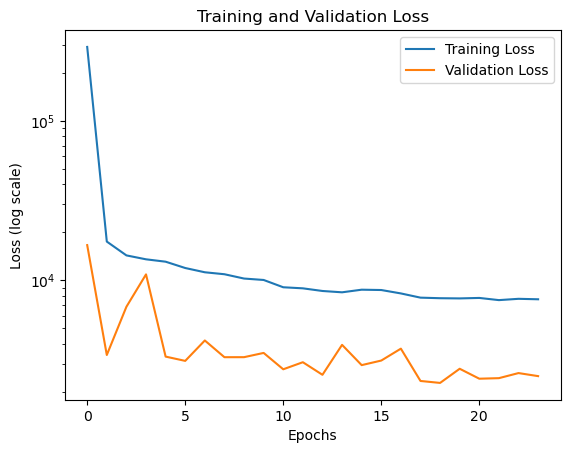

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


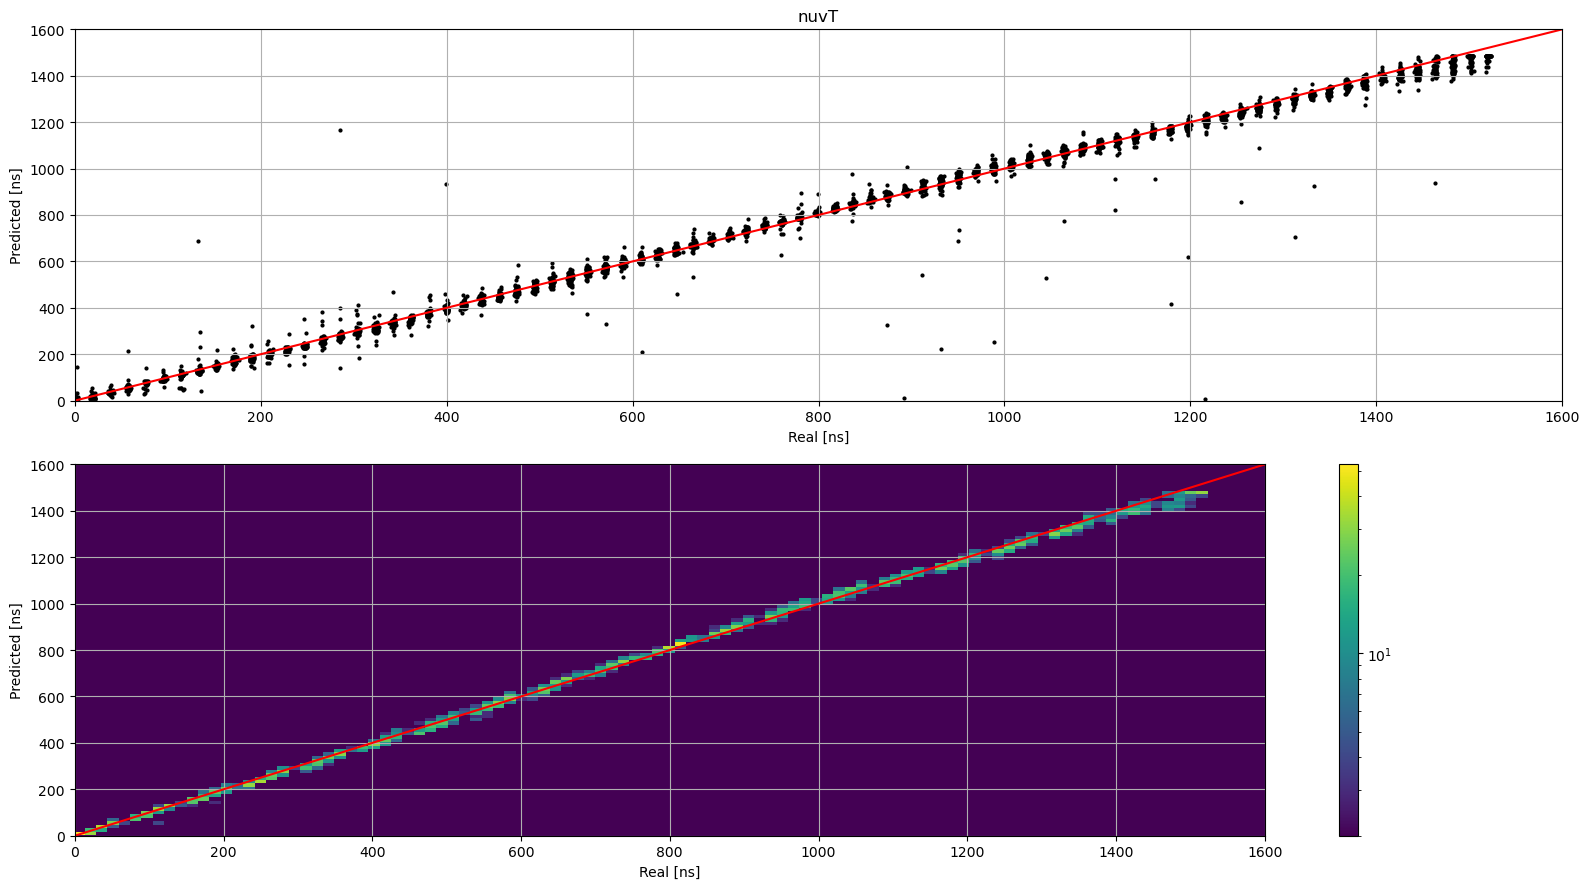

In [18]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,1,figsize=(16,9))

axs[0].scatter(y_temp, y_pred, color="black",s=4)
axs[0].grid()

axs[0].plot([0,1600],[0,1600],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1600])
axs[0].set_ylim([0,1600])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

im0 = axs[1].hist2d(y_temp, y_pred.flatten(), bins=(100, 100), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1600],[0,1600],'r')
axs[1].set_xlim([0,1600])
axs[1].set_ylim([0,1600])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')



fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

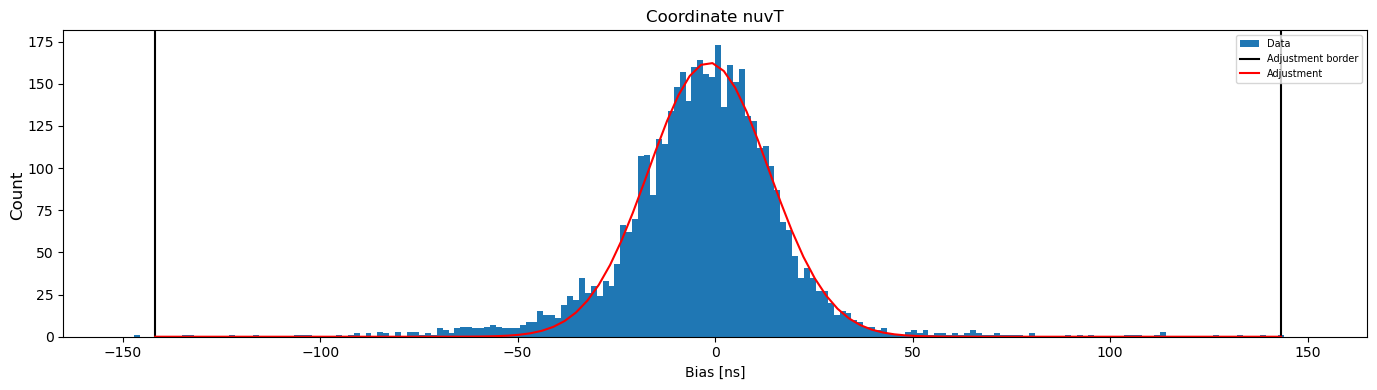

Bias Adjustment variables
------------------
Mean nuvT = -1.62
Sigma nuvT = 15.26
------------------


In [19]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = ak.flatten(y_pred) - y_temp

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, ax, coord_name, ini, fin, hist_range):
    counts, bins, patches = ax.hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    ax.axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    ax.axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    ax.plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    ax.set_xlabel('Bias [ns]')  # Set different xlabel for nuvT
    ax.set_title(f'Coordinate {coord_name}')
    ax.legend(prop={"size": 7})

    return popt

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 4))

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, ax, 'nuvT', 5, 195, hist_range=[-150, 150])

# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
